In [2]:
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # supprime certains warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np

In [13]:

# X = pd.read_csv("../Prix_metre/UX_avec_prix_et_images_complet_et_inflation.csv")
X = pd.read_csv("../Prix_metre/X_insee.csv")
# X = pd.read_csv("../Prix_metre/essai_big_INSEE.csv")
# X = pd.read_csv("../Prix_metre/X_test.csv")
X = X.drop(columns = ["gray_mean","quartile_inf","quartile_sup"])
y_train = pd.read_csv("../y_train_OXxrJt1.csv")
X_test = pd.read_csv("../Anciens Datasets/X_test_avec_prix.csv")
X_train = pd.read_csv("../Anciens Datasets/X_train_avec_prix.csv")

X.rename(columns = {'Prixm2_Moy':'Prix_2018','Prixm2' : 'Prix_2017'}, inplace = True)
annonces = X_test.id_annonce
y_train = y_train.drop(columns = ['id_annonce'])

## Feature Engineering

In [14]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        if X[x].isnull().sum()/len(X[x])*100 > 0:
            Features_incomplete.append(x)
    return Features_incomplete

def FE(X):
    X.drop(columns = ["exposition"],inplace=True)
    X.drop(columns=['ghg_category', 'energy_performance_category'], inplace=True)
    X['floor'].fillna(0, inplace=True)
    X['land_size'].fillna(0, inplace=True)

    #one hot encoding for property_type
    X = pd.get_dummies(X, columns=['property_type'], drop_first=False)

    # Label encoding for city
    #le = LabelEncoder()
    #X['city'] = le.fit_transform(X['city'])
    
    # Frequency encoding for city
    X['city'] = X['city'].map(X['city'].value_counts())


    # Calcul des valeurs des départements plutôt que des codes postaux (en séparant les départements à 4 chiffres des départements à 5 chiffres)
    X["departement"]=X["postal_code"]
    X["departement"][X["departement"] < 10000]=X["departement"].astype(str).str[:1].astype(int)
    X["departement"][X["departement"] >= 10000]=X["departement"].astype(str).str[:2].astype(int)

    # Tentatives de remplir les valeurs manquantes de ces colonnes par la valeur moyenne pour le code postal associé
    X["POPULATION_x"].fillna(X.groupby("postal_code")["POPULATION_x"].transform("mean"), inplace=True)
    X["Nb_Transac"].fillna(X.groupby("postal_code")["Nb_Transac"].transform("mean"), inplace=True)
    X["Nb_Ventes"].fillna(X.groupby("postal_code")["Nb_Ventes"].transform("mean"), inplace=True)
    
    X["nearly_price"]=X["PrixMoyen_M2"]*X["size"]
    X["nearly_price_1819"]=X["PrixMoyen_M2_1819"]*X["size"]
    X["prix_metre"] = np.sqrt(X["PrixMoyen_M2"])
    X["prix_metre_1819"] = np.sqrt(X["PrixMoyen_M2_1819"])
    #------------------------------
    X["prix_metre_2017"] = np.sqrt(X["Prix_2017"])
    X["prix_metre_2018"] = np.sqrt(X["Prix_2018"])
    X["racine_size"] = np.sqrt(X["size"])
    X["racine_land_size"] = np.sqrt(X["land_size"])
    
    X["Somme_bedrooms_rooms"] = X["nb_rooms"]+X["nb_bedrooms"]
    X["Somme_bathrooms_rooms"] = X["nb_rooms"]+X["nb_bathrooms"]
    X["Diff_bedrooms_bathrooms"] = X["nb_bathrooms"]-X["nb_bedrooms"]

  
    
    

    # Prendre l'entier de la longitude et de la latitude
    X["approximate_longitude"]=X["approximate_longitude"].astype(int)
    X["approximate_latitude"]=X["approximate_latitude"].astype(int)
    
    
    for x in ["approximate_longitude","approximate_latitude","nearly_price"]:
    # On remplit le reste par la valeur moyenne du département
        X[x].fillna(X.groupby("departement")[x].transform("mean"), inplace=True)
    


    
    X = X.drop(columns = ["id_annonce"],axis=1)

    return X



In [15]:
def preprocessing(X_train, X_test):
    scaler = MinMaxScaler()
    for x in X_train.columns:
        if X_train[x].dtype != 'object':
            X_train[x] = scaler.fit_transform(X_train[x].values.reshape(-1,1))
            X_test[x] = scaler.transform(X_test[x].values.reshape(-1,1))

    # création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
    X_cluster_size = X_train[["approximate_longitude","approximate_latitude","nearly_price"]]

    N=15
    kmeans = KMeans(n_clusters=N)
    X_cluster_size["Cluster"] = kmeans.fit_predict(X_cluster_size)
    X_cluster_size["Cluster"] = X_cluster_size["Cluster"].astype("category")
    X_train["Cluster"]=X_cluster_size["Cluster"]
    X_test["Cluster"]=kmeans.predict(X_test[["approximate_longitude","approximate_latitude","nearly_price"]])

    scaler = MinMaxScaler()
    for x in X_train.columns:
        if X_train[x].dtype != 'object':
            X_train[x] = scaler.fit_transform(X_train[x].values.reshape(-1,1))
            X_test[x] = scaler.transform(X_test[x].values.reshape(-1,1))
    
    return X_train, X_test

In [16]:
X = FE(X)

In [17]:
X_train = X.iloc[:len(X_train),:]
X_test = X.iloc[len(X_train):,:]

In [18]:
X_train, X_test = preprocessing(X_train, X_test)

## Création d'un modèle de XGBoost

#### Modèle choisi

In [24]:
y_log_train = np.log1p(y_train)
y_log_train = y_log_train.reset_index(drop=True)

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X_train, y_log_train, test_size=0.2, random_state=8)

my_kfold = KFold(n_splits = 5,shuffle = True)
features_improv = {"n_estimators" :[x for x in range(4000, 7000, 1000)], "max_depth" : [x for x in range(6,12,1)], "learning_rate" : [x/200 for x in range(1,10,1)], "subsample" : [x/10 for x in range(5,10,1)], "colsample_bytree" : [x/10 for x in range(1,10,1)]}

#xgbc = GridSearchCV(xgb.XGBRegressor(),param_grid=features_improv,cv=my_kfold,n_jobs=-1)
#xgbc.fit(train_X,train_y)
#print(xgbc.best_params_)

In [13]:
# HalvingGridSearch
features_improv2 = {"n_estimators" :[x for x in range(4000, 7000, 1000)], "max_depth" : [x for x in range(6,12,1)], "learning_rate" : [x/200 for x in range(1,10,1)]}
xgbc = HalvingGridSearchCV(xgb.XGBRegressor(eval_metric="mape"),param_grid=features_improv2,cv=5,n_jobs=-1)
xgbc.fit(train_X,train_y)
print(xgbc.best_params_)

KeyboardInterrupt: 

In [ ]:
# Après GridSearchCV 2 par 2, on obtient les paramètres suivants : n_estimators=5000, max_depth=9, learning_rate=0.01, subsample=0.7, colsample_bytree=0.3

In [26]:
# xgb_best = xgb.XGBRegressor(eval_metric = "mape",n_estimators=5000,max_depth = 9,learning_rate=0.08,colsample_bytree=0.5, subsample=0.9,n_jobs=-1)
xgb_best = xgb.XGBRegressor(eval_metric = "mape",n_estimators=5000,max_depth = 9,learning_rate=0.08, colsample_bytree=0.5, subsample=0.9,n_jobs=-1)

xgb_best.fit(X_train,y_log_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mape', feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [27]:
from sklearn.metrics import mean_absolute_percentage_error
prediction = xgb_best.predict(X_train)
mean_absolute_percentage_error(y_train, np.expm1(prediction))*100

0.10839076008493877

In [28]:
prediction_y = xgb_best.predict(X_test)

Y_final = pd.DataFrame({"price" : np.expm1(prediction_y)})
Y_final.set_index(annonces, inplace=True)

Y_final.to_csv("y_pred_12_01_4.csv")

In [33]:
y_1 = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/Test_ML/y_pred_27_12_5.csv")

y_1.head()

,id_annonce,price
0,35160615,173982.90
1,35830639,986306.50
2,36016657,196440.67
3,35759225,253061.30
4,35252229,430512.30


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

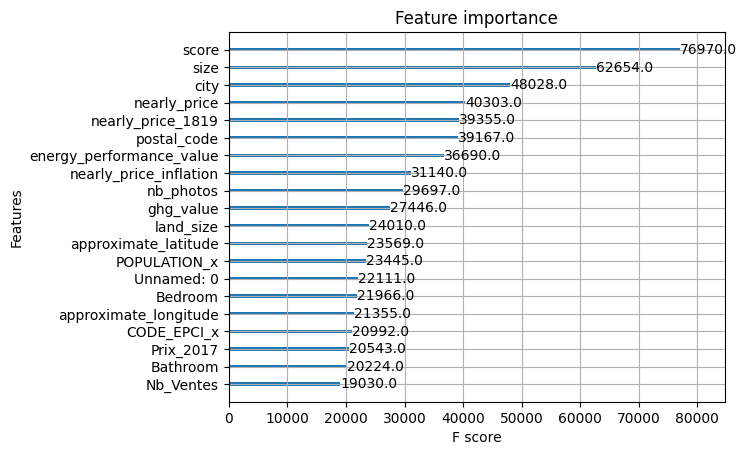

In [23]:
# Importance des features
xgb.plot_importance(xgb_best,max_num_features = 20)
    

#### Récup de la prédiction finale

> Qu'est ce que Unnamed: 0 ?

In [14]:
X[["energy_performance_value"]]

,Unnamed: 0
0,14319.0
1,4850.0
2,883.0
3,15741.0
4,34847.0
...,...
46702,34088.0
46703,NaN
46704,26881.0
46705,6679.0


> Test d'arrondissement des valeurs

In [9]:
y_a_arrondir = pd.read_csv("./y_pred_30_12_inflation_corrigee.csv")

In [10]:
# On arrondit les prix au millier le plus proche
y_a_arrondir["price"] = y_a_arrondir["price"].apply(lambda x : round(x,-3))

In [12]:
y_a_arrondir.head()

,id_annonce,price
0,35160615,193000.0
1,35830639,786000.0
2,36016657,209000.0
3,35759225,217000.0
4,35252229,445000.0


In [11]:
y_a_arrondir.to_csv("y_pred_30_12_inflation_corrigee_arrondi.csv",index=False)

# Tentative ensemble learning

In [13]:
# import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
# create an Ensemble Learning method using XGBoost, LightGBM and CatBoost

train_X, test_X, train_y, test_y = train_test_split(X_train, y_log_train, test_size=0.2, random_state=8)
    # create a list of models
models = []
# models.append(('LGBM', lgb.LGBMRegressor(metric = "mape", n_estimators=5000, max_depth=9, learning_rate=0.01, subsample=0.7, colsample_bytree=0.3)))
models.append(('XGB', xgb.XGBRegressor(eval_metric = "mape", n_estimators=5000, max_depth=9, learning_rate=0.01, subsample=0.7, colsample_bytree=0.3)))
models.append(('CAT', CatBoostRegressor(loss_function="MAPE")))

    # create a list of predictions
predictions = []
for name, model in models:
    # fit the model
    model.fit(train_X, train_y)
    # make predictions
    y_pred = model.predict(test_X)
    # store predictions
    predictions.append(y_pred)
    # evaluate predictions
    mape = mean_absolute_percentage_error(test_y, y_pred)*100
    print('%s: %f' % (name, mape))

XGB: 1.806249
0:	learn: 0.0504249	total: 9.63ms	remaining: 9.62s
1:	learn: 0.0496492	total: 17.9ms	remaining: 8.95s
2:	learn: 0.0488875	total: 26ms	remaining: 8.63s
3:	learn: 0.0481746	total: 33.9ms	remaining: 8.44s
4:	learn: 0.0474783	total: 42.2ms	remaining: 8.39s
5:	learn: 0.0468238	total: 50.3ms	remaining: 8.33s
6:	learn: 0.0461950	total: 59.1ms	remaining: 8.38s
7:	learn: 0.0455472	total: 67.8ms	remaining: 8.41s
8:	learn: 0.0449468	total: 76.2ms	remaining: 8.39s
9:	learn: 0.0443927	total: 84.5ms	remaining: 8.36s
10:	learn: 0.0438100	total: 93.6ms	remaining: 8.41s
11:	learn: 0.0432658	total: 103ms	remaining: 8.48s
12:	learn: 0.0427338	total: 113ms	remaining: 8.58s
13:	learn: 0.0422500	total: 123ms	remaining: 8.63s
14:	learn: 0.0417628	total: 131ms	remaining: 8.62s
15:	learn: 0.0412908	total: 141ms	remaining: 8.65s
16:	learn: 0.0408042	total: 149ms	remaining: 8.64s
17:	learn: 0.0403730	total: 160ms	remaining: 8.71s
18:	learn: 0.0399067	total: 169ms	remaining: 8.71s
19:	learn: 0.03944

In [14]:
predictions = np.array(predictions).T
predictions = pd.DataFrame(predictions)

# create a meta learner
meta_learner = LinearRegression()
# fit the meta learner
meta_learner.fit(predictions, test_y)
# make predictions
y_pred = meta_learner.predict(predictions)
# evaluate predictions
mape = mean_absolute_percentage_error(test_y,y_pred)*100
print('Meta Learner: %f' % (mape))

Meta Learner: 1.804190


In [27]:
predictions = []
for name, model in models:
    y_pred = model.predict(X_test)
    predictions.append(y_pred)

df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
predictions = pd.concat([df1, df2], axis=1) 
prediction_y = meta_learner.predict(predictions)
pred_y_list = [item for sublist in prediction_y for item in sublist]

print(prediction_y)
Y_final = pd.DataFrame({"price" : np.expm1(pred_y_list)})
Y_final.set_index(annonces, inplace=True)

Y_final.to_csv("y_pred_09_01.csv")

[[11.97922768]
 [13.64537975]
 [12.16434959]
 ...
 [12.71991703]
 [12.71242497]
 [12.45726577]]


# Ensemble learning à la main

In [25]:
# CatBoost, LightGBM, XGBoost
from catboost import CatBoostRegressor
#from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


#lgbm = LGBMRegressor(metric = "mape", n_estimators=5000, max_depth=9, learning_rate=0.01, subsample=0.7, colsample_bytree=0.3)
#lgbm.fit(X_train, y_log_train)

xgb = XGBRegressor(eval_metric = "mape", n_estimators=5000, max_depth=9, learning_rate=0.01, subsample=0.7, colsample_bytree=0.3)
xgb = xgb.fit(X_train, y_log_train)

cat = CatBoostRegressor(loss_function="MAPE")
cat.fit(X_train, y_log_train)

final_predict = 0.75*xgb.predict(X_test) + 0.25*cat.predict(X_test)

Y_final = pd.DataFrame({"price" : np.expm1(final_predict)})



0:	learn: 0.0503443	total: 102ms	remaining: 1m 42s
1:	learn: 0.0495549	total: 129ms	remaining: 1m 4s
2:	learn: 0.0488074	total: 144ms	remaining: 47.9s
3:	learn: 0.0481058	total: 156ms	remaining: 38.7s
4:	learn: 0.0474275	total: 170ms	remaining: 33.8s
5:	learn: 0.0467375	total: 184ms	remaining: 30.5s
6:	learn: 0.0461006	total: 198ms	remaining: 28.1s
7:	learn: 0.0454675	total: 214ms	remaining: 26.5s
8:	learn: 0.0448501	total: 233ms	remaining: 25.6s
9:	learn: 0.0442607	total: 249ms	remaining: 24.6s
10:	learn: 0.0436884	total: 268ms	remaining: 24.1s
11:	learn: 0.0431366	total: 283ms	remaining: 23.3s
12:	learn: 0.0425903	total: 299ms	remaining: 22.7s
13:	learn: 0.0420541	total: 326ms	remaining: 23s
14:	learn: 0.0415341	total: 359ms	remaining: 23.6s
15:	learn: 0.0410276	total: 394ms	remaining: 24.2s
16:	learn: 0.0405450	total: 484ms	remaining: 28s
17:	learn: 0.0401129	total: 564ms	remaining: 30.8s
18:	learn: 0.0396735	total: 601ms	remaining: 31s
19:	learn: 0.0392425	total: 625ms	remaining: 3

In [26]:
# to csv
Y_final.set_index(annonces, inplace=True)
Y_final.to_csv("y_pred_09_01_2.csv")

In [ ]:
# Avec un meta-learner

from sklearn.linear_model import LinearRegression

# create a list of predictions
models = []
models.append(('XGB', xgb.XGBRegressor(eval_metric = "mape", n_estimators=5000, max_depth=9, learning_rate=0.01, subsample=0.7, colsample_bytree=0.3)))
models.append(('CAT', CatBoostRegressor(loss_function="MAPE")))
models.append(('LGBM', lgb.LGBMRegressor(metric = "mape", n_estimators=5000, max_depth=9, learning_rate=0.01, subsample=0.7, colsample_bytree=0.3)))



predictions = []
for name, model in models:
    # fit the model
    model.fit(X_train, y_log_train)
    # make predictions
    y_pred = model.predict(X_test)
    # store predictions
    predictions.append(y_pred)
    
predictions = np.array(predictions).T
predictions = pd.DataFrame(predictions)

# create a meta learner
meta_learner = LinearRegression()
# fit the meta learner
meta_learner.fit(predictions, y_log_test)
# make predictions
y_pred = meta_learner.predict(predictions)



    

##### Valeurs après GridSearch avec la bonne métrique : 'n_estimators = 2000', 'max_depth' = 3, 'learning_rate' = 0.045, 'subsample' = 0.7